In [2]:
import os
import os.path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = ''
df = pd.read_csv(path)

Mounted at /content/drive


<ipython-input-3-0fa61b054670>:5: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [4]:
attributes = ['total_pop', 'nonhisp_white_perc', 'hisp_perc', 'nonhisp_black_perc', 'two_plus_races_perc', 'nonhisp_asian_perc', 'year', 'zip']
df = df[attributes]
df = df.dropna(subset=['year'])
df = df.dropna(subset=['zip'])
df['year'] = df['year'].astype(int)
df['zip'] = df['zip'].astype(int)
df = df[df['total_pop'] != 0]
df = df.drop(columns=['total_pop'])

In [5]:
df = df.sort_values(['zip', 'year'])
perc_cols = ['nonhisp_white_perc', 'hisp_perc', 'nonhisp_black_perc', 'two_plus_races_perc', 'nonhisp_asian_perc']
for col in perc_cols:
    df[col + '_diff'] = df.groupby('zip')[col].diff()

In [ ]:
df.head()
print(df.isna().sum().sum())
print(len(df))

167295
295011


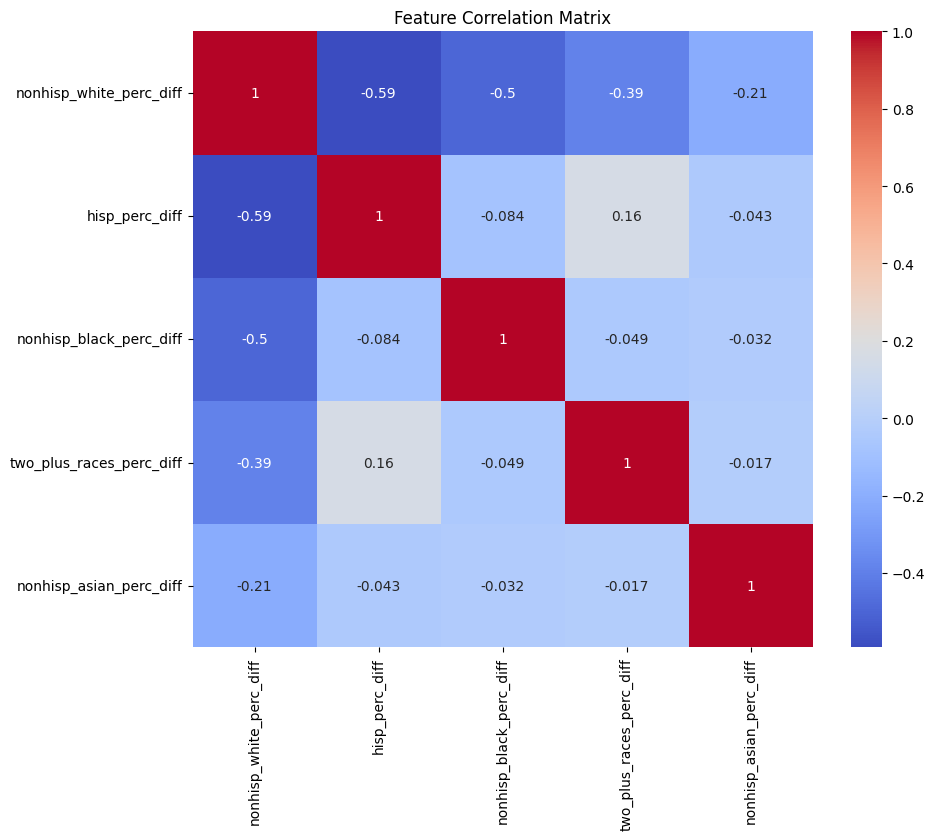

In [23]:
perc_chg_cols = ['nonhisp_white_perc_diff', 'hisp_perc_diff', 'nonhisp_black_perc_diff', 'two_plus_races_perc_diff', 'nonhisp_asian_perc_diff']

# Compute correlation matrix to pinpoint highly correlated x's prior to pca
correlation_matrix = df[perc_chg_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
pip install factor_analyzer

In [15]:
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

In [21]:
kmo_all, kmo_model = calculate_kmo(df[perc_chg_cols])
chi_square_value, p_value = calculate_bartlett_sphericity(df[perc_chg_cols])

print(f"KMO Test statistic: {kmo_model:.4f}")
print(f"Bartlett’s Test p-value: {p_value:.4f}")

KMO Test statistic: 0.5205
Bartlett’s Test p-value: 0.0000


Prior to conducting principal component analysis (PCA), the Kaiser-Meyer-Olkin (KMO) test and Bartlett’s Test of Sphericity were used to assess the suitability of the variables.
The KMO statistic was 0.5205, indicating mediocre sampling adequacy but sufficient to cautiously proceed with PCA.
Bartlett’s Test was highly significant (p < 0.001), suggesting that the variables are sufficiently correlated to justify dimensionality reduction through PCA.
Together, these tests support the use of PCA while highlighting the moderate strength of the underlying correlation structure

# PCA

In [7]:
df = df.sort_values(['zip', 'year'])
df = df[df['year'] != 2015]
df = df.dropna()

start_year = 2015
end_year = 2023

# Create an empty list / dict to collect results / loadings
results = []
pc1_loadings = {}

# Rolling 5-year window
for base_year in range(start_year, end_year - 4):  # -4 so you still get a full 5-year window
    window_years = list(range(base_year, base_year + 5))
    print(f"Processing window {window_years}")

    # 1. Subset the data
    df_window = df[df['year'].isin(window_years)].copy()

    # 2. Extract feature matrix
    X = df_window[perc_chg_cols]

    # 3. Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 4. PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # 5. Save PC1, zip, year
    pca_temp = pd.DataFrame({
        'PC1': X_pca[:, 0],
        'zip': df_window['zip'].values,
        'year': df_window['year'].values,
        'window_start': base_year,
        'window_end': base_year + 4
    })
    print('Variance explained by PC1:', pca.explained_variance_ratio_[0])
    print('Variance explained by PC2:', pca.explained_variance_ratio_[1])
    print('Variance explained by PC3:', pca.explained_variance_ratio_[2], '\n')


    # 6. Save PCA loadings for Analysis
    loadings = pd.DataFrame(
        pca.components_.T,
        index=perc_chg_cols,
        columns=[f'PC{i+1}' for i in range(X_scaled.shape[1])]
    )
    pc1_loadings[(base_year, base_year + 4)] = loadings['PC1'].values
    results.append(pca_temp)

    print(f"Window {base_year}-{base_year+4} PCA Loadings:")
    print('PC1:\n', loadings['PC1'], ', \nPC2:\n', loadings['PC2'], ', \nPC3:\n', loadings['PC3'], sep = '')
    print("\n" + "="*50 + "\n")

pca_df = pd.concat(results).reset_index(drop=True)

Processing window [2015, 2016, 2017, 2018, 2019]
Variance explained by PC1: 0.3717757827423968
Variance explained by PC2: 0.22038309785709584
Variance explained by PC3: 0.20274226845392004 

Window 2015-2019 PCA Loadings:
PC1:
nonhisp_white_perc_diff     0.721115
hisp_perc_diff             -0.482924
nonhisp_black_perc_diff    -0.355323
two_plus_races_perc_diff   -0.313927
nonhisp_asian_perc_diff    -0.148233
Name: PC1, dtype: float64, 
PC2:
nonhisp_white_perc_diff    -0.055661
hisp_perc_diff             -0.501307
nonhisp_black_perc_diff     0.813485
two_plus_races_perc_diff   -0.288579
nonhisp_asian_perc_diff     0.023599
Name: PC2, dtype: float64, 
PC3:
nonhisp_white_perc_diff    -0.020440
hisp_perc_diff             -0.128352
nonhisp_black_perc_diff    -0.155401
two_plus_races_perc_diff   -0.131803
nonhisp_asian_perc_diff     0.970354
Name: PC3, dtype: float64


Processing window [2016, 2017, 2018, 2019, 2020]
Variance explained by PC1: 0.37592994029425497
Variance explained by PC2: 0

##**Interpretation**
**PC1:** White displacement of minority populations, capturing the primary variance in racial demographic change associated with gentrification patterns described in the literature.

  *~37% Displacement of minorities (classic gentrification axis)*

**PC2:**	Black-specific movement, semi-independent of White/Hispanic patterns

  *~22% Independent Black demographic shifts*

**PC3:**	Asian-specific growth/movement, largely orthogonal to others

  *~20% Asian-specific migration dynamics*
  
-------

This indicates a moderately strong latent structure,
with PC1 representing the principal axis of racial demographic displacement,
while allowing for multi-dimensional secondary patterns.


# Congruence testing

In [8]:
# Tucker's congruence coefficient between two loading vectors (pairwise cosine similarity)
def factor_congruence(a, b):
    return np.sum(a * b) / (np.sqrt(np.sum(a ** 2)) * np.sqrt(np.sum(b ** 2)))

In [9]:
sorted_windows = sorted(pc1_loadings.keys())

congruences = []

for i in range(len(sorted_windows) - 1):
    w1, w2 = sorted_windows[i], sorted_windows[i+1]
    loadings1 = pc1_loadings[w1]
    loadings2 = pc1_loadings[w2]

    phi = factor_congruence(loadings1, loadings2)

    congruences.append({
        'window1': w1,
        'window2': w2,
        'factor_congruence': phi
    })

congruence_df = pd.DataFrame(congruences)
print(congruence_df)

        window1       window2  factor_congruence
0  (2015, 2019)  (2016, 2020)           0.999617
1  (2016, 2020)  (2017, 2021)           0.999849
2  (2017, 2021)  (2018, 2022)           0.999519


In [11]:
all_pc1_loadings = np.array([loadings for loadings in pc1_loadings.values()])
mean_loading = np.mean(all_pc1_loadings, axis=0)

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

similarities = []

for window, loading in zip(pc1_loadings.keys(), all_pc1_loadings):
    sim = cosine_similarity(loading, mean_loading)
    similarities.append({'window': window, 'cosine_similarity_to_mean': sim})
similarity_df = pd.DataFrame(similarities)
global_congruence = np.mean(similarity_df['cosine_similarity_to_mean'])

print(similarity_df)
print(f"\nGlobal average congruence across all windows: {global_congruence:.6f}")

         window  cosine_similarity_to_mean
0  (2015, 2019)                   0.999338
1  (2016, 2020)                   0.999953
2  (2017, 2021)                   0.999956
3  (2018, 2022)                   0.999286

Global average congruence across all windows: 0.999633


Tucker’s congruence coefficients for the first principal component (PC1) across all rolling five-year windows exceeded 0.95, indicating that the PC1 structure remained highly stable over time. This strong stability validates the use of PC1 as a consistent proxy for racial demographic displacement throughout the study period.

The displacement dimension (PC1) is extremely stable across all rolling windows with an average congruence of 0.999 relative to the common mean.

In [35]:
duplicate = pca_df

In [36]:
duplicate = duplicate[duplicate['year'] == duplicate['window_end']]
duplicate.drop(columns=['window_start', 'window_end'], inplace=True)
duplicate.rename(columns={'PC1': 'displacement'}, inplace=True)
duplicate = duplicate.sort_values(by=['zip', 'year'])
duplicate.head()

<ipython-input-36-9c1044997003>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicate.drop(columns=['window_start', 'window_end'], inplace=True)
<ipython-input-36-9c1044997003>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicate.rename(columns={'PC1': 'displacement'}, inplace=True)


,displacement,zip,year
3,0.146860,1001,2019
130507,-0.325602,1001,2020
293594,0.190034,1001,2021
456468,-0.523897,1001,2022
7,-0.006707,1002,2019


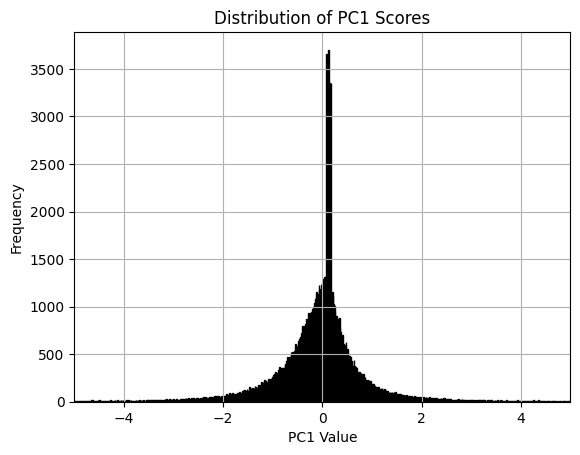

In [42]:
plt.hist(duplicate['displacement'], bins=5000, edgecolor='black')
plt.title('Distribution of PC1 Scores')
plt.xlabel('PC1 Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(-5, 5)
plt.show()

In [45]:
# traditional form of finding outliers for
Q1 = duplicate['displacement'].quantile(0.25)
Q3 = duplicate['displacement'].quantile(0.75)
IQR = Q3 - Q1

outliers = duplicate[(duplicate['displacement'] < Q1 - 1.5 * IQR) | (duplicate['displacement'] > Q3 + 1.5 * IQR)]

print(outliers)
print(len(duplicate))

        displacement    zip  year
130542     -2.553176   1010  2020
293654      1.490202   1022  2021
293689      2.253792   1032  2021
130702     -2.157983   1070  2020
163        -1.714796   1071  2019
...              ...    ...   ...
619670     -1.897186  99836  2022
293540     -3.974835  99841  2020
456413     -8.354247  99841  2021
619680      7.847919  99841  2022
456463     -1.621981  99929  2021

[14994 rows x 3 columns]
130634


In [64]:
print(len(duplicate[duplicate['displacement'] > 4]))

1256


Among the ~11.5% of PC1 outliers, only a subset with strongly positive PC1 scores are indicative of gentrification-related White influx.
Negative PC1 outliers represent large demographic shifts in the opposite direction, consistent with minority-driven neighborhood change rather than classic gentrification.

Note: mixture dist of discreteleptokurtic normal dist , 4131 values over 2, 2129 over 3, 1256 over 4

The distribution of PC1 scores approximates a Laplace distribution, characterized by a sharp central peak and heavy tails.
This suggests that most ZIP codes experience minor demographic shifts, while a minority experience substantial displacement pressures.

Fitted Laplace Parameters:
Location (mu) = 0.0775
Scale (b) = 0.6385


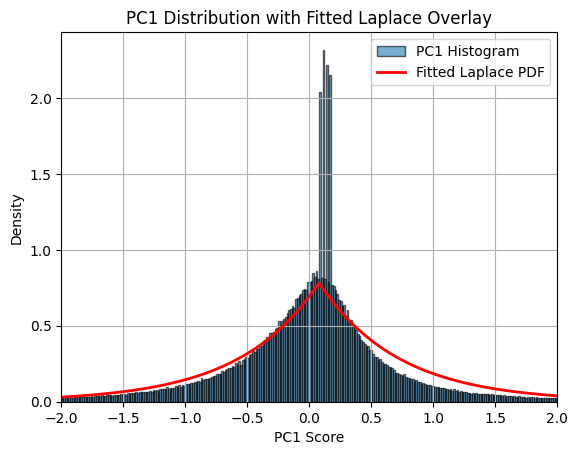

In [67]:
from scipy.stats import laplace

# 1. Fit Laplace distribution
mu, b = laplace.fit(pca_df['PC1'])

print(f"Fitted Laplace Parameters:\nLocation (mu) = {mu:.4f}\nScale (b) = {b:.4f}")

# 2. Plot histogram
plt.hist(pca_df['PC1'], bins=5000, density=True, alpha=0.6, edgecolor='black', label='PC1 Histogram')

# 3. Overlay fitted Laplace PDF
x = np.linspace(-2, 2, 1000)  # 👈 Limit x range to [-2, 2] for plotting PDF
pdf = laplace.pdf(x, loc=mu, scale=b)

plt.plot(x, pdf, 'r-', lw=2, label='Fitted Laplace PDF')

plt.xlim(-2, 2)  # 👈 Set visible x-axis limits
plt.title('PC1 Distribution with Fitted Laplace Overlay')
plt.xlabel('PC1 Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


The distribution of PC1 scores approximates a Laplace distribution for neighborhoods undergoing displacement, with a discrete probability mass at zero reflecting the substantial proportion of neighborhoods experiencing demographic stability.
This mixed structure is consistent with incomplete gentrification, where displacement pressure is highly localized rather than uniform across all areas

In [68]:
duplicate.to_csv(path + 'displacement.csv', index=False)